In [37]:
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt
from tqdm import tqdm
import json

In [38]:
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

In [39]:
xp = np
print(xp.__name__)
cp.__version__

numpy


'10.3.0'

In [40]:
parameters = dict(
hbar = 1,
m = 1,
x_max = 20,
Nx = 10000,
Neng = 600000,
E_interval = (0.0001, 3),
save_path = './Ndat_03/',
)

In [41]:
p = parameters

m = p['m']
hbar = p['hbar']
x_max = p['x_max']
Nx = p['Nx']
Neng = p['Neng']
save_path = p['save_path']

dx = 2.0 * x_max / Nx
hbar_inv = 1.0 / hbar

x = xp.linspace(-x_max, x_max, Nx)
E = xp.linspace(*p['E_interval'], Neng)

In [42]:
def potential(x):
    x2 = x**2
    V = (x2 / 2.0 - 0.8) * xp.exp(-0.1 * x2)
    return V

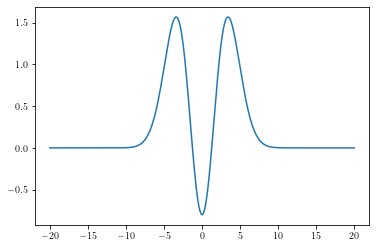

In [43]:
%matplotlib inline
plt.plot(cp.asnumpy(x), cp.asnumpy(potential(x)))
plt.show()

In [44]:
def propagator2(psi1, psi2, x, E, typ="back", store=True, pars=parameters): 
    if store:        
        #pth = "./scatterF_data_02/"
        pth = pars['save_path']
        
        xp.save(pth+"file_psi_{:.5f}".format(float(x[-1])), xp.append(float(x[-1]),psi2))
        xp.save(pth+"file_psi_{:.5f}".format(float(x[-2])), xp.append(float(x[-2]),psi1))
        xp.save(pth+"coordinates", x)
        xp.save(pth+"energies", E)
        with open(pth+'parameters.json','w') as f:
            f.write(json.dumps(pars))
    
    if typ=="back":
        for xn in tqdm(list(reversed(x[0:-1]))):
            cf1 = 2.0 * (1.0 - m * dx**2 * hbar_inv**2 * (E - potential(xn)))
            psi0 = cf1 * psi1 - psi2
            psi2 = psi1
            psi1 = psi0
            
            if store:
                xp.save(pth+"file_psi_{:.5f}".format(float(xn)), xp.append(xn,psi0))
                
    else:
        pass
                            
    return psi1, psi2

def get_coeff2(psi0, psi1, x, eng, store=True, pars=parameters):
    K = hbar_inv * xp.sqrt(2 * m * E)
    exponents = xp.array(list(map(lambda n: xp.array([K * x[n] * 1.0j, -K * x[n] * 1.0j]), [0, 1] )))
    mat = xp.exp(exponents)

    ab = list()
    for n in range(0, mat.shape[2]):
        ab.append(xp.dot(xp.linalg.inv(mat[:,:,n]), xp.array([psi00[n], psi01[n]])))
    ab = xp.array(ab)
    aa, bb = ab.T

    T = 1.0 / aa
    R = T * bb
    
    if store:        
        pth = pars['save_path']
        xp.save(pth+"R", R)
        xp.save(pth+"T", T)
    
    return R, T

def reduce_to(array,min_val,max_val, step=1):
    id_min = np.where(array >= min_val)[0][0] 
    id_max = np.where(array <= max_val)[0][-1]
    short = array[id_min:id_max+1]
    sift = np.arange(0, short.size, step)
    
    if step == 1:
        return short
    elif step > 1:
        return short.take(sift)
    
k = lambda e: hbar_inv * xp.sqrt(2 * m * e)

In [10]:
# version 2 - vectorized
xp = cp

k = lambda e: hbar_inv * xp.sqrt(2 * m * e)

psi2 = xp.exp(k(E) * x[-1] * 1.0j)
psi1 = xp.exp(k(E) * x[-2] * 1.0j)

psi00, psi01 = propagator2(psi1, psi2, x, E, store=True, pars=parameters)
R, T = get_coeff2(psi00, psi01, x, E, store=True, pars=parameters)

100%|█████████████████████████████████████████████████████████████████████████████████| 9999/9999 [02:13<00:00, 74.83it/s]


TypeError: Unsupported type <class 'numpy.ndarray'>

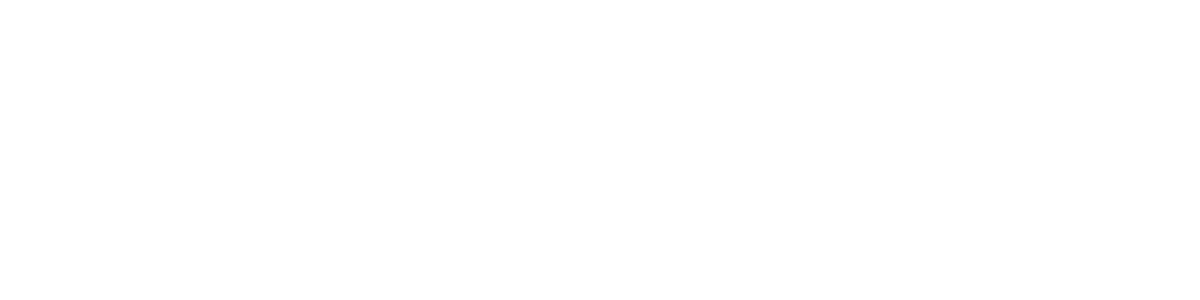

In [14]:
plt.figure(figsize=(8,2),dpi=150)
plt.plot(cp.asnumpy(E), cp.asnumpy(cp.abs(T)**2))
plt.show()

In [47]:
# processing
%time
import os
from os import path

directory = "./Ndat_02/"
xp = np

energies = xp.load(directory+"energies.npy")
posi = xp.load(directory+"coordinates.npy")
T = xp.load(directory+"T.npy")
pos = xp.array([posi[0],])

for i in posi:
    if i > pos[-1]+0.1:
        pos = xp.append(pos, i)

pos = reduce_to(xp.array(pos),-20,20)

energy = reduce_to(energies, 0.001,3)
#energy = reduce_to(energies, 0.615,0.627)
#energy = reduce_to(energies, 1.16,1.5)

estep = 3
#estep = 1

esift = np.arange(0, energy.shape[0], estep)
energy = energy.take(esift)
#print(energy.shape)

zdata = xp.array([0]*int(pos.shape[0]),dtype=complex)
ydata = xp.array([0])
xdata = xp.array([0])

c = 70000

shift = np.where(energies >= energy[0])[0][0]

k = lambda e: np.sqrt(2 * e)

for cnt in tqdm(list(range(0, int(np.ceil(energy.shape[0]/c))))):
    psi_data = xp.array([0]*( min(c,energy.shape[0]-cnt*c) +1))
    eng = energy[ cnt*c : (cnt+1)*c ]
    
    int1 = (cnt)*c +1
    #int2 = min( (cnt + 1) * c+shift, energy.shape[0] )+1
    int2 = int1 + eng.shape[0]
    
    for d in pos:
        pt = directory+"file_psi_{:.5f}.npy".format(d)
        if not path.exists(pt):
            continue

        data = xp.load(pt, mmap_mode='r').take(np.append([0],esift+1+shift))

        dt = xp.append(data[0], data[int1:int2]) 
        psi_data = xp.vstack([psi_data, dt])
            
    psi_data2 = psi_data[1:]
    psi_data2T = psi_data2[psi_data2[:,0].argsort()].T
    
    # 1:
    #export = psi_data2T[1:] / xp.max(xp.abs(psi_data2T[1:]),axis=1)[:,xp.newaxis]
    # 2:
    export = psi_data2T[1:] * cp.asnumpy(T.take(esift+shift)[int1-1:int2-1,np.newaxis]) * np.sqrt(m * hbar_inv**2 / (2*np.pi * k(eng)))[:,np.newaxis]
    
    zdata = xp.vstack([zdata, export])
    # zdata = np.vstack([zdata, np.real(psi_data2T[1])])
    ydata = xp.append(ydata, eng)
    #print(eng[0],eng[-1], eng.shape, psi_data2T.shape)
    
    if xdata.shape[0] == 1:
        xdata = psi_data2T[0]

CPU times: total: 0 ns
Wall time: 0 ns


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:00<00:00, 40.09s/it]


GridSpec(2, 4, height_ratios=[1, 8], width_ratios=[3, 26, 1, 1])


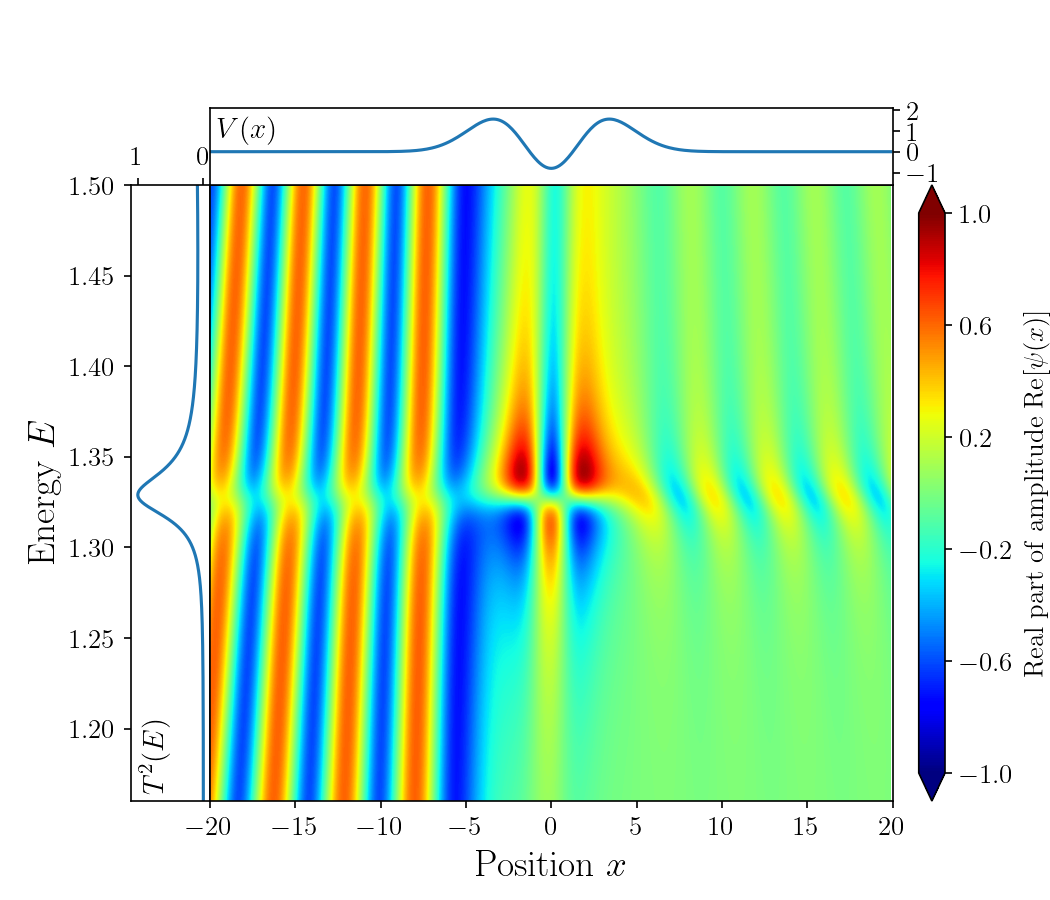

In [13]:
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=150, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(ncols=4, nrows=2, height_ratios=[1,8], width_ratios=[3,26,1,1], figure=fig) 
print(gs)
ax3 = plt.subplot(gs[4])
ax0 = plt.subplot(gs[5], sharey = ax3)
ax1 = plt.subplot(gs[1], sharex = ax0)
ax4 = plt.subplot(gs[7])

ax0.set_xlim(-20,20)
#ax3.set_ylim(0,3)
#ax3.set_ylim(0.615,0.627)
ax3.set_ylim(1.16,1.5)
#ax0.set_ylim(0,3)

x, y = np.meshgrid(np.real(xdata), np.real(ydata[1:]))
cs = ax0.contourf(x, y, np.real(zdata[1:]), 500, vmax=1, vmin=-1, 
                  levels=np.linspace(-1,1,600),
                  cmap="jet",extend='both',
                 )
#cs = ax0.contourf(xxx, yyy, zX_real, 500, vmax=1, vmin=-1, cmap="jet",)
plt.colorbar(cs, cax=ax4, ticks=np.linspace(-1,1,6),label="$\mathrm{Real\ part\ of\ amplitude}\ \mathrm{Re}[\psi(x)]$")
#plt.colorbar(cs, cax=ax4, ticks=np.linspace(-1,1,6),label="$\mathrm{Imaginary\ part\ of\ amplitude}\ \mathrm{Im}[\psi(x)]$")
# ax.set_xlabel("Position", fontsize=18)
# ax.set_ylabel("Energy", fontsize=18)

T = cp.asnumpy(T)
E = cp.asnumpy(E)

ax1.plot(pos, potential(pos))
ax1.set_ylim(-1.6, 2.1)
ax1.set_yticks([-1, 0, 1, 2])

ax3.plot(np.abs(T)**2, E)
ax3.set_xlim( 1.1, -0.1)
ax3.set_xticks([0, 1])

plt.setp(ax0.get_yticklabels(), visible=False)
plt.setp(ax0.get_yticklines(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklines(), visible=False)
ax1.yaxis.tick_right()

ax3.xaxis.set_label_position('top')
ax3.xaxis.tick_top()

plt.subplots_adjust(hspace=.0, wspace=0.0)

# place a text box in upper left in axes coords
ax1.text(0.01, 0.9, "$V(x)$", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top')
ax3.text(0.1, 0.01, "$T^2(E)$", transform=ax3.transAxes, fontsize=14, rotation=90,
        verticalalignment='bottom', horizontalalignment='left')


ax0.set_xlabel("$\mathrm{Position}\ x$", fontsize=18)
ax3.set_ylabel("$\mathrm{Energy}\ E$", fontsize=18)
plt.show()

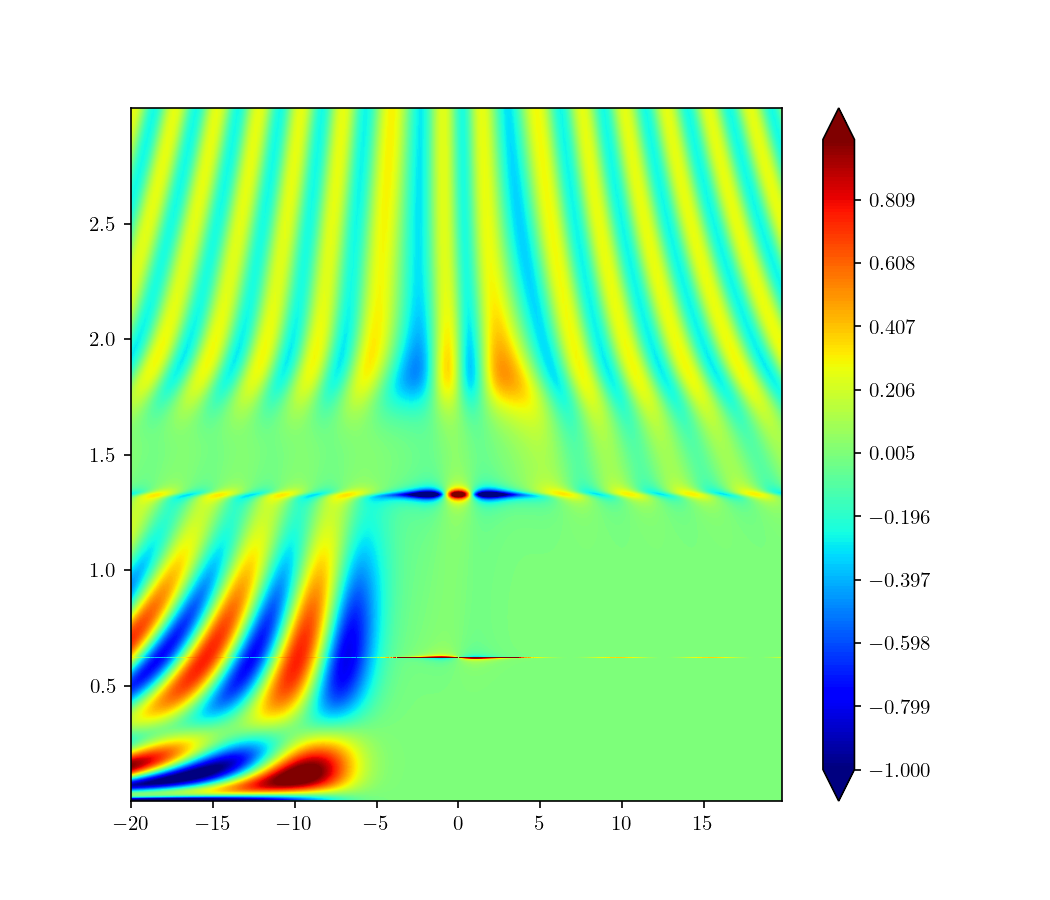

RuntimeError: You must first define an image, e.g., with imshow

In [23]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import ticker

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=150, facecolor='w', edgecolor='k')

# ax.set_xlim(-20,20)
# ax.set_ylim(0,3)
# ax.set_zlim(-10,10)

x, y = np.meshgrid(np.real(xdata), np.real(ydata[1:]))
cs = ax.contourf(x, y, np.imag(zdata[1:]), 100, 
                 vmax=1, vmin=-1, 
                 levels=np.linspace(-1,1,200),
                 cmap="jet",extend='both',
                 #locator=ticker.SymmetricalLogLocator(linthresh=0.1,base=np.e),#subs=[2, 4, 6, 8]),
                )
plt.colorbar(cs)#, ticks=np.linspace(-1,1,6))
plt.show()

In [101]:
zdata[1:].min(), zdata[1:].max()

((-0.01580290991146855-0.008103799703968564j),
 (0.01400444114349788+0.007181540421621388j))

In [45]:
def plot_slices(intervals, **kwargs):
    from matplotlib import rc
    from matplotlib import gridspec
    import numpy as np
    from os import path
    
    xp=np
    
    # if typ == "real":
    #     func = np.real
    #     lab = "$\mathrm{Real\ part}$"
    # elif typ == "img":
    #     func = np.imag
    #     lab = "$\mathrm{Imaginary\ part}$"

    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
    rc('text', usetex=True)
    rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

    fig = plt.figure(figsize=(10,4),dpi=200)
    ax = fig.add_subplot()
    ax.set_xlim(-20,20)
    ax.set_ylim(-1.1, 1.1)
    
    directory = "./Ndat_02/"
    temp = np.load(directory+"energies.npy")
    pos = np.load(directory+"coordinates.npy")
    T = np.load(directory+"T.npy")
    TT = np.abs(T)**2
    zdata = xp.array([0]*int(pos.shape[0]),dtype=complex)
    
    for pair in intervals:
        i1, i2 = pair
        id1 = np.where(temp > i1)[0][0]
        id2 = np.where(temp < i2)[0][-1]

        id01 = np.where(TT == max(TT[int(id1):int(id2)]))[0][0]

        eng = np.array(temp)[id01]
        ps01 = np.array([0,0])
        print(id01, eng)      
        
        for d in pos:
            pt = directory+"file_psi_{:.5f}.npy".format(d)
            if not path.exists(pt):
                continue

            data = xp.load(pt, mmap_mode='r')
            dt = xp.append(data[0], data[int(id01)+1])
            ps01 = xp.vstack([ps01, dt])
            
        ps02 = ps01[1:]
        ps03 = ps02[ps02[:,0].argsort()].T
        print('ps03: :', ps03[1].shape, type(ps03))
        export = ps03[1] * T[id01] * np.sqrt(m * hbar_inv**2 / (2*np.pi * k(eng)))#[:,np.newaxis]
        print(export.shape, np.max(np.abs(export)**2))
        
        nrm = 1 #max(np.max(np.abs(np.real(export))), np.max(np.abs(np.imag(export))))
        
        p = plt.plot(np.real(ps03[0]), np.real(export) /nrm, label="$\mathrm{Re},\ $"+"$E={:.3f}$".format(eng), linewidth=1, **kwargs)
        plt.plot(np.real(ps03[0]), np.imag(export)/nrm, label="$\mathrm{Im},\ $"+"$E={:.3f}$".format(eng), linewidth=1, linestyle="dotted", color=p[-1].get_color(), **kwargs)

    plt.xlabel("$\mathrm{Position}$", fontsize=18)
    plt.ylabel("$\mathrm{Amplitude}$", fontsize=18)
    plt.ylim(-1.1,1.1)

    plt.plot(pos, [0]*len(pos), [0, 0], [-2, 2], color='k', linewidth=0.2)

    plt.legend(loc='lower center', prop={'size': 13}, frameon=False, bbox_to_anchor=(0.5, 1.05),ncol=len(intervals))
    plt.tight_layout()
    plt.show()

265781 1.3289629179381965
ps03: : (10000,) <class 'numpy.ndarray'>
(10000,) 2.7834593336601188


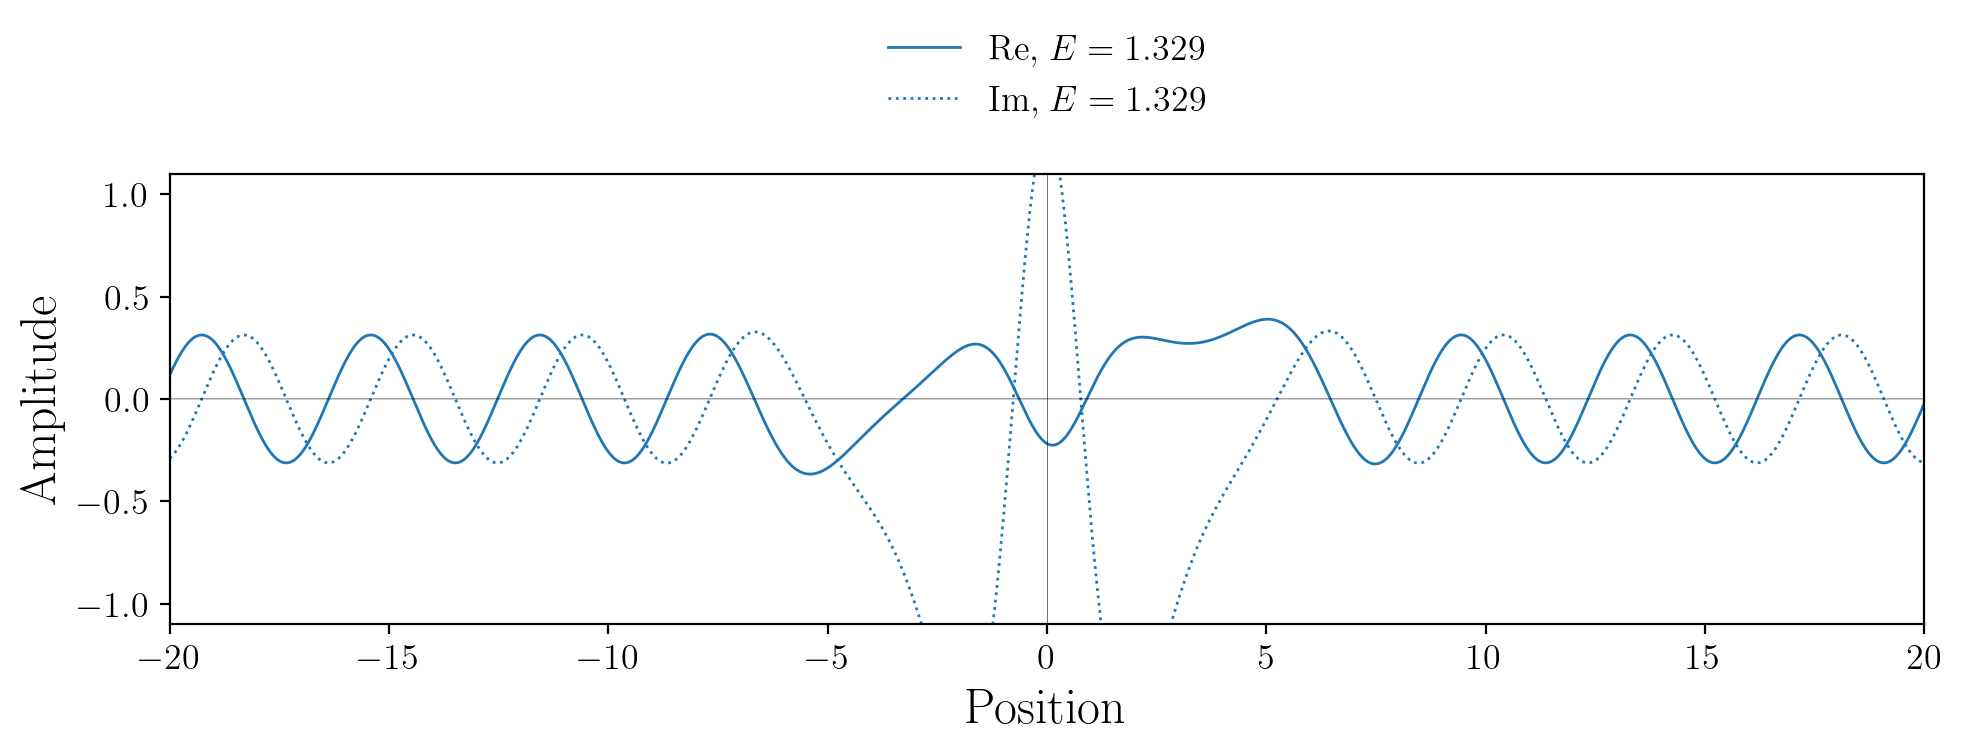

In [46]:
plot_slices([[1.2,1.4],])

In [10]:
from mayavi import mlab
import numpy as np

In [18]:
%gui qt
mlab.clf()
#srf = mlab.surf(zX_img.T, extent=[-20,20,0,30,-2,2])

ext = [-20,20,0,30,-15,15]
rng = [-20,20,0,3,-15,15]

#ext = [-20,20,0,40,-15,15]
#rng = [-20,20,0.615,0.627,-15,15]

#ext = [-20,20,0,40,-3,3]
#rng = [-20,20,1.15,1.5,-3,3]

srf = mlab.surf(np.imag(zdata[1:]).T, extent=ext)
#srf = mlab.surf(zzz.T, extent=[-20,20,0.615,0.627,-2,2])
sax = mlab.axes(srf, z_axis_visibility=False, extent=ext, ranges=rng)
mlab.colorbar(orientation='vertical')
mlab.xlabel("Position")
mlab.ylabel("Energy")

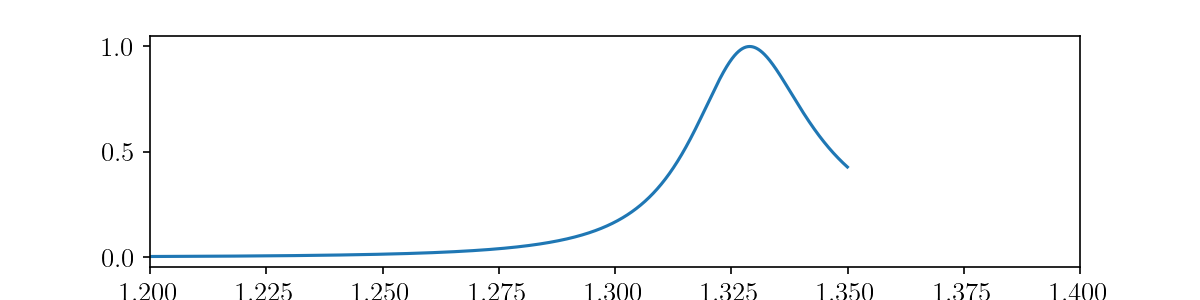

In [172]:
plt.figure(figsize=(8,2),dpi=150)
plt.plot(cp.asnumpy(energy), cp.asnumpy(cp.abs(T.take(esift+shift))**2))
plt.xlim(1.2, 1.35)
plt.show()

In [128]:
energy.shape, T.take(esift+shift).shape

((667,), (667,))